## Setup

### Imports

In [ ]:
import numpy as np
np.bool = np.bool_ # bad trick to fix numpy version issue :(
import os
import sys
import shutil
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["DISPLAY"] = ":0"
os.environ["PYOPENGL_PLATFORM"] = "egl"

### Constants

In [2]:
# constants
TASK = 'open_drawer'
DATA_FOLDER ='peract_colab/data'
EPISODES_FOLDER = 'colab_dataset/open_drawer/all_variations/episodes'
EPISODE_FOLDER = 'episode%d'
CAMERAS = ['front', 'left_shoulder', 'right_shoulder', 'wrist']
LOW_DIM_SIZE = 4   # {left_finger_joint, right_finger_joint, gripper_open, timestep}
IMAGE_SIZE =  128  # 128x128 - if you want to use higher voxel resolutions like 200^3, you might want to regenerate the dataset with larger images
VARIATION_DESCRIPTIONS_PKL = 'variation_descriptions.pkl' # the pkl file that contains language goals for each demonstration
EPISODE_LENGTH = 10 # max steps for agents
DEMO_AUGMENTATION_EVERY_N = 10 # sample n-th frame in demo
ROTATION_RESOLUTION = 5 # degree increments per axis

# settings
VOXEL_SIZES = [100] # 100x100x100 voxels
NUM_LATENTS = 512 # PerceiverIO latents
SCENE_BOUNDS = [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6] # [x_min, y_min, z_min, x_max, y_max, z_max] - the metric volume to be voxelized
BATCH_SIZE = 1
NUM_DEMOS = 8 # total number of training demonstrations to use while training PerAct
NUM_TEST = 2 # episodes to evaluate on

### Data Paths

In [3]:
sys.path.append('peract_colab')
data_path = os.path.join(DATA_FOLDER, EPISODES_FOLDER)

train_replay_storage_dir = 'replay_train'
if not os.path.exists(train_replay_storage_dir):
  os.mkdir(train_replay_storage_dir)

test_replay_storage_dir = 'replay_test'
if not os.path.exists(test_replay_storage_dir):
  os.mkdir(test_replay_storage_dir)

## Data Loading & Preprocessing

### Load Demos

class Observation(object):


```
# Storage for both visual and low-dimensional observations.
left_shoulder_rgb: np.ndarray,
left_shoulder_depth: np.ndarray,
left_shoulder_mask: np.ndarray,
left_shoulder_point_cloud: np.ndarray,
right_shoulder_rgb: np.ndarray,
right_shoulder_depth: np.ndarray,
right_shoulder_mask: np.ndarray,
right_shoulder_point_cloud: np.ndarray,
overhead_rgb: np.ndarray,
overhead_depth: np.ndarray,
overhead_mask: np.ndarray,
overhead_point_cloud: np.ndarray,
wrist_rgb: np.ndarray,
wrist_depth: np.ndarray,
wrist_mask: np.ndarray,
wrist_point_cloud: np.ndarray,
front_rgb: np.ndarray,
front_depth: np.ndarray,
front_mask: np.ndarray,
front_point_cloud: np.ndarray,
joint_velocities: np.ndarray,
joint_positions: np.ndarray,
joint_forces: np.ndarray,
gripper_open: float,
gripper_pose: np.ndarray,
gripper_matrix: np.ndarray,
gripper_joint_positions: np.ndarray,
gripper_touch_forces: np.ndarray,
task_low_dim_state: np.ndarray,
ignore_collisions: np.ndarray,
misc: dict,
```


misc:

```
    left_shoulder_camera_extrinsics
    left_shoulder_camera_intrinsics
    left_shoulder_camera_near
    left_shoulder_camera_far
    right_shoulder_camera_extrinsics
    right_shoulder_camera_intrinsics
    right_shoulder_camera_near
    right_shoulder_camera_far
    overhead_camera_extrinsics
    overhead_camera_intrinsics
    overhead_camera_near
    overhead_camera_far
    front_camera_extrinsics
    front_camera_intrinsics
    front_camera_near
    front_camera_far
    wrist_camera_extrinsics
    wrist_camera_intrinsics
    wrist_camera_near
    wrist_camera_far
    wrist_camera_matrix
```

Demo 1 | 108 total steps



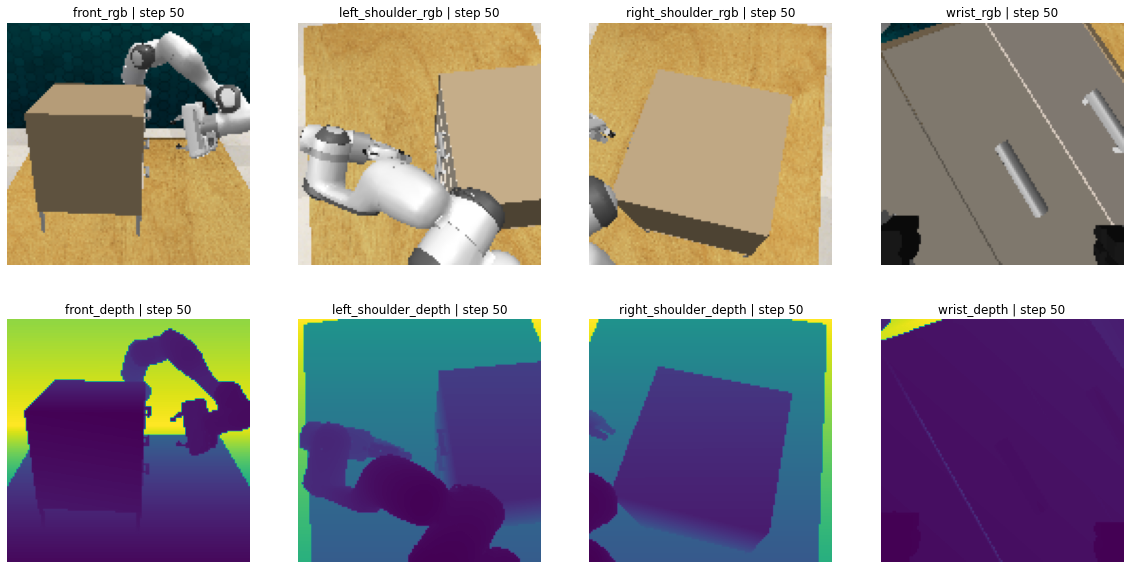

In [4]:
from rlbench.utils import get_stored_demo
from rlbench.backend.observation import Observation
from rlbench.backend.utils import extract_obs

REMOVE_KEYS = ['joint_velocities', 'joint_positions', 'joint_forces',
               'gripper_open', 'gripper_pose',
               'gripper_joint_positions', 'gripper_touch_forces',
               'task_low_dim_state', 'misc']

# what to visualize
episode_idx_to_visualize = 1 # out of 10 demos
ts = 50 # timestep out of total timesteps

# get demo
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)

# extract obs at timestep
obs_dict = extract_obs(demo._observations[ts], CAMERAS, t=ts)

# total timesteps in demo
print(f"Demo {episode_idx_to_visualize} | {len(demo._observations)} total steps\n")

# plot rgb and depth at timestep
fig = plt.figure(figsize=(20, 10))
rows, cols = 2, len(CAMERAS)

plot_idx = 1
for camera in CAMERAS:
  # rgb
  rgb_name = "%s_%s" % (camera, 'rgb')
  rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
  fig.add_subplot(rows, cols, plot_idx)
  plt.imshow(rgb)
  plt.axis('off')
  plt.title("%s_rgb | step %s" % (camera, ts))

  # depth
  depth_name = "%s_%s" % (camera, 'depth')
  depth = np.transpose(obs_dict[depth_name], (1, 2, 0)).reshape(IMAGE_SIZE, IMAGE_SIZE)
  fig.add_subplot(rows, cols, plot_idx+len(CAMERAS))
  plt.imshow(depth)
  plt.axis('off')
  plt.title("%s_depth | step %s" % (camera, ts))

  plot_idx += 1

plt.show()

In [31]:
np.transpose(obs_dict['left_shoulder_point_cloud'], (1,2,0))[64,64,:]

array([0.2846425 , 0.11895251, 0.97908795], dtype=float32)

In [ ]:
# fig = plt.figure(figsize=(20,5))

# img = demo._observations[ts].front_rgb
# obs_dict = extract_obs(demo._observations[ts], CAMERAS, t=ts)

# extracted_img = obs_dict['front_rgb']



# fig.add_subplot(1,1,1)
# plt.imshow(img)

# fig.add_subplot(1,2,2)
# plt.imshow(np.transpose(extracted_img, (1,2,0)))

# plt.show()

### Create Replay Buffer


#### From Section 3.4
Replay buffer stores **<observation, language goal, keyframe action>** tuples sampled from demonstrations
- For translation,  the ground-truth action is represented as a one-hot voxel encoding Y trans: H×W×D
- For Rotations, the ground-truth action is represented with a one-hot encoding per rotation axis with R rotation bins Y rot :  (360/R)×3 (Where R = 5 degrees for all experiments).



replay buffer:

```
{'_disk_saving': True,
 '_save_dir': 'replay_train',
 '_purge_replay_on_shutdown': True,
 '_action_shape': (8,),
 '_action_dtype': numpy.float32,
 '_reward_shape': (),
 '_reward_dtype': numpy.float32,
 '_timesteps': 1,
 '_replay_capacity': 300000,
 '_batch_size': 1,
 '_update_horizon': 1,
 '_gamma': 0.99,
 '_max_sample_attempts': 10000,
 '_observation_elements': [<yarr.utils.observation_type.ObservationElement at 0x7f0309962b50>,
  <yarr.utils.observation_type.ObservationElement at 0x7f0309962bb0>,
...
  <yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a340>],
 '_extra_replay_elements': [<yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a3a0>],
 '_storage_signature': [<yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a580>,
  <yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a640>,
...
  <yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a3a0>],
 '_obs_signature': [<yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a730>,
  <yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a790>,
...
  <yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d39130>],
 '_store': {'terminal': array([-1, -1, -1, ..., -1, -1, -1], dtype=int8)},
 '_lock': <Lock(owner=None)>,
 '_add_count': <Synchronized wrapper for c_int(0)>,
 'invalid_range': array([0.]),
 '_cumulative_discount_vector': array([1.], dtype=float32)}
```


observation element:

```
{'name': 'low_dim_state', 'shape': (4,), 'type': <class 'numpy.float32'>}
{'name': 'front_rgb', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'front_depth', 'shape': (1, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'front_point_cloud', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'front_camera_extrinsics', 'shape': (4, 4), 'type': <class 'numpy.float32'>}
{'name': 'front_camera_intrinsics', 'shape': (3, 3), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_rgb', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_depth', 'shape': (1, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_point_cloud', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_camera_extrinsics', 'shape': (4, 4), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_camera_intrinsics', 'shape': (3, 3), 'type': <class 'numpy.float32'>}
{'name': 'right_shoulder_rgb', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'right_shoulder_depth', 'shape': (1, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'right_shoulder_point_cloud', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'right_shoulder_camera_extrinsics', 'shape': (4, 4), 'type': <class 'numpy.float32'>}
{'name': 'right_shoulder_camera_intrinsics', 'shape': (3, 3), 'type': <class 'numpy.float32'>}
{'name': 'wrist_rgb', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'wrist_depth', 'shape': (1, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'wrist_point_cloud', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'wrist_camera_extrinsics', 'shape': (4, 4), 'type': <class 'numpy.float32'>}
{'name': 'wrist_camera_intrinsics', 'shape': (3, 3), 'type': <class 'numpy.float32'>}
{'name': 'trans_action_indicies', 'shape': (3,), 'type': <class 'numpy.int32'>, 'is_observation': False}
{'name': 'rot_grip_action_indicies', 'shape': (4,), 'type': <class 'numpy.int32'>, 'is_observation': False}
{'name': 'ignore_collisions', 'shape': (1,), 'type': <class 'numpy.int32'>, 'is_observation': False}
{'name': 'gripper_pose', 'shape': (7,), 'type': <class 'numpy.float32'>, 'is_observation': False}
{'name': 'lang_goal_embs', 'shape': (77, 512), 'type': <class 'numpy.float32'>, 'is_observation': False}
{'name': 'lang_goal', 'shape': (1,), 'type': <class 'object'>, 'is_observation': False}
```

In [5]:
# Adapted from: https://github.com/stepjam/ARM/blob/main/arm/c2farm/launch_utils.py

from yarr.utils.observation_type import ObservationElement
from yarr.replay_buffer import ReplayElement, ReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer import UniformReplayBuffer


def create_replay(batch_size: int,
                  timesteps: int,
                  save_dir: str,
                  cameras: list,
                  voxel_sizes,
                  replay_size=3e5):

    trans_indicies_size = 3 * len(voxel_sizes)
    rot_and_grip_indicies_size = (3 + 1)
    gripper_pose_size = 7
    ignore_collisions_size = 1
    max_token_seq_len = 77
    lang_feat_dim = 1024
    lang_emb_dim = 512

    # low_dim_state
    observation_elements = []
    observation_elements.append(
        ObservationElement('low_dim_state', (LOW_DIM_SIZE,), np.float32))

    # rgb, depth, point cloud, intrinsics, extrinsics
    for cname in cameras:
        observation_elements.append(
            ObservationElement('%s_rgb' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_depth' % cname, (1, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_point_cloud' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32)) # see pyrep/objects/vision_sensor.py on how pointclouds are extracted from depth frames
        observation_elements.append(
            ObservationElement('%s_camera_extrinsics' % cname, (4, 4,), np.float32))
        observation_elements.append(
            ObservationElement('%s_camera_intrinsics' % cname, (3, 3,), np.float32))

    # discretized translation, discretized rotation, discrete ignore collision, 6-DoF gripper pose, and pre-trained language embeddings
    observation_elements.extend([
        ReplayElement('trans_action_indicies', (trans_indicies_size,),
                      np.int32),
        ReplayElement('rot_grip_action_indicies', (rot_and_grip_indicies_size,),
                      np.int32),
        ReplayElement('ignore_collisions', (ignore_collisions_size,),
                      np.int32),
        ReplayElement('gripper_pose', (gripper_pose_size,),
                      np.float32),
        ReplayElement('lang_goal_embs', (max_token_seq_len, lang_emb_dim,), # extracted from CLIP's language encoder
                      np.float32),
        ReplayElement('lang_goal', (1,), object), # language goal string for debugging and visualization
    ])

    extra_replay_elements = [
        ReplayElement('demo', (), np.bool),
    ]

    replay_buffer = UniformReplayBuffer( # all tuples in the buffer have equal sample weighting
        save_dir=save_dir,
        batch_size=batch_size,
        timesteps=timesteps,
        replay_capacity=int(replay_size),
        action_shape=(8,), # 3 translation + 4 rotation quaternion + 1 gripper open
        action_dtype=np.float32,
        reward_shape=(),
        reward_dtype=np.float32,
        update_horizon=1,
        observation_elements=observation_elements,
        extra_replay_elements=extra_replay_elements
    )
    return replay_buffer

train_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                    timesteps=1,
                                    save_dir=train_replay_storage_dir,
                                    cameras=CAMERAS,
                                    voxel_sizes=VOXEL_SIZES)

test_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                   timesteps=1,
                                   save_dir=test_replay_storage_dir,
                                   cameras=CAMERAS,
                                   voxel_sizes=VOXEL_SIZES)


In [7]:
vars(train_replay_buffer)

{'_disk_saving': True,
 '_save_dir': 'replay_train',
 '_purge_replay_on_shutdown': True,
 '_action_shape': (8,),
 '_action_dtype': numpy.float32,
 '_reward_shape': (),
 '_reward_dtype': numpy.float32,
 '_timesteps': 1,
 '_replay_capacity': 300000,
 '_batch_size': 1,
 '_update_horizon': 1,
 '_gamma': 0.99,
 '_max_sample_attempts': 10000,
 '_observation_elements': [<yarr.utils.observation_type.ObservationElement at 0x7f0309962b50>,
 '_extra_replay_elements': [<yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a3a0>],
 '_storage_signature': [<yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a580>,
 '_obs_signature': [<yarr.replay_buffer.replay_buffer.ReplayElement at 0x7f0309d2a730>,
 '_store': {'terminal': array([-1, -1, -1, ..., -1, -1, -1], dtype=int8)},
 '_lock': <Lock(owner=None)>,
 '_add_count': <Synchronized wrapper for c_int(0)>,
 'invalid_range': array([0.]),
 '_cumulative_discount_vector': array([1.], dtype=float32)}

In [16]:
for element in train_replay_buffer._observation_elements:
    print(vars(element))

{'name': 'low_dim_state', 'shape': (4,), 'type': <class 'numpy.float32'>}
{'name': 'front_rgb', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'front_depth', 'shape': (1, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'front_point_cloud', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'front_camera_extrinsics', 'shape': (4, 4), 'type': <class 'numpy.float32'>}
{'name': 'front_camera_intrinsics', 'shape': (3, 3), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_rgb', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_depth', 'shape': (1, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_point_cloud', 'shape': (3, 128, 128), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_camera_extrinsics', 'shape': (4, 4), 'type': <class 'numpy.float32'>}
{'name': 'left_shoulder_camera_intrinsics', 'shape': (3, 3), 'type': <class 'numpy.float32'>}
{'name': 'right_shoulder_rgb', 'shape': (3, 128,

In [23]:
train_replay_buffer._observation_elements[26].shape

(1,)

### KeyFrame Extraction

##### Heurestic for KeyFrame
1. join-velocities near zero
2. gripper state has not changed


Note: generated demonstrations might take various paths to execute the "opening" motion, but all paths strictly pass through these **bottleneck** poses

In [24]:
# From https://github.com/stepjam/ARM/blob/main/arm/demo_loading_utils.py

from rlbench.demo import Demo
from typing import List

def _is_stopped(demo, i, obs, stopped_buffer, delta=0.1):
    next_is_not_final = i == (len(demo) - 2)
    gripper_state_no_change = (
            i < (len(demo) - 2) and
            (obs.gripper_open == demo[i + 1].gripper_open and
             obs.gripper_open == demo[i - 1].gripper_open and
             demo[i - 2].gripper_open == demo[i - 1].gripper_open))
    small_delta = np.allclose(obs.joint_velocities, 0, atol=delta)
    stopped = (stopped_buffer <= 0 and small_delta and
               (not next_is_not_final) and gripper_state_no_change)
    return stopped

def _keypoint_discovery(demo: Demo,
                        stopping_delta=0.1) -> List[int]:
    episode_keypoints = []
    prev_gripper_open = demo[0].gripper_open
    stopped_buffer = 0
    for i, obs in enumerate(demo):
        stopped = _is_stopped(demo, i, obs, stopped_buffer, stopping_delta)
        stopped_buffer = 4 if stopped else stopped_buffer - 1
        # if change in gripper, or end of episode.
        last = i == (len(demo) - 1)
        if i != 0 and (obs.gripper_open != prev_gripper_open or
                        last or stopped):
            episode_keypoints.append(i)
        prev_gripper_open = obs.gripper_open
    if len(episode_keypoints) > 1 and (episode_keypoints[-1] - 1) == \
            episode_keypoints[-2]:
        episode_keypoints.pop(-2)
    print('Found %d keypoints.' % len(episode_keypoints), episode_keypoints)
    return episode_keypoints

Demo 1 | 108 total steps
Found 3 keypoints. [64, 77, 107]


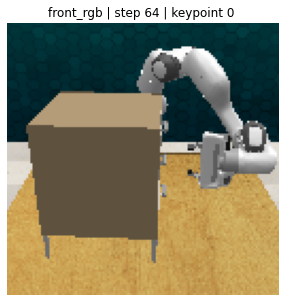

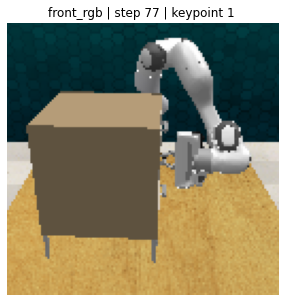

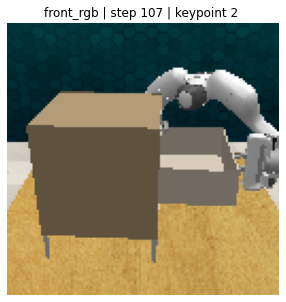

In [25]:
# use Demo 1 like last time
episode_idx_to_visualize = 1
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)

# total timesteps
print("Demo %s | %s total steps" % (episode_idx_to_visualize, len(demo._observations)))

# use the heuristic to extract keyframes (aka keypoints)
episode_keypoints = _keypoint_discovery(demo)

# visualize rgb observations from these keyframes
for kp_idx, kp in enumerate(episode_keypoints):
    obs_dict = extract_obs(demo._observations[kp], CAMERAS, t=kp)

    fig = plt.figure(figsize=(5, 5))
    rgb_name = "front_rgb"
    rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("front_rgb | step %s | keypoint %s " % (kp, kp_idx))
    plt.show()

### Fill Replay

In [ ]:
# fill replay

import clip
import torch
import arm.utils as utils

# from rlbench.backend.observation import Observation # imported above
from yarr.replay_buffer.replay_buffer import ReplayBuffer

# discretize translation, rotation, gripper open, and ignore collision actions
def _get_action(
        obs_tp1: Observation,
        obs_tm1: Observation,
        rlbench_scene_bounds: List[float], # metric 3D bounds of the scene
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool):
    quat = utils.normalize_quaternion(obs_tp1.gripper_pose[3:])
    if quat[-1] < 0:
        quat = -quat
    disc_rot = utils.quaternion_to_discrete_euler(quat, rotation_resolution)
    attention_coordinate = obs_tp1.gripper_pose[:3]
    trans_indicies, attention_coordinates = [], []
    bounds = np.array(rlbench_scene_bounds)
    ignore_collisions = int(obs_tm1.ignore_collisions)
    for depth, vox_size in enumerate(voxel_sizes): # only single voxelization-level is used in PerAct
        index = utils.point_to_voxel_index(
            obs_tp1.gripper_pose[:3], vox_size, bounds)
        trans_indicies.extend(index.tolist())
        res = (bounds[3:] - bounds[:3]) / vox_size
        attention_coordinate = bounds[:3] + res * index
        attention_coordinates.append(attention_coordinate)

    rot_and_grip_indicies = disc_rot.tolist()
    grip = float(obs_tp1.gripper_open)
    rot_and_grip_indicies.extend([int(obs_tp1.gripper_open)])
    return trans_indicies, rot_and_grip_indicies, ignore_collisions, np.concatenate(
        [obs_tp1.gripper_pose, np.array([grip])]), attention_coordinates

# extract CLIP language features for goal string
def _clip_encode_text(clip_model, text):
    x = clip_model.token_embedding(text).type(clip_model.dtype)  # [batch_size, n_ctx, d_model]

    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = clip_model.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clip_model.ln_final(x).type(clip_model.dtype)

    emb = x.clone()
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ clip_model.text_projection

    return x, emb

# add individual data points to replay
def _add_keypoints_to_replay(
        replay: ReplayBuffer,
        inital_obs: Observation,
        demo: Demo,
        episode_keypoints: List[int],
        cameras: List[str],
        rlbench_scene_bounds: List[float],
        voxel_sizes: List[int],
        rotation_resolution: int,
        crop_augmentation: bool,
        description: str = '',
        clip_model = None,
        device = 'cpu'):
    prev_action = None
    obs = inital_obs
    for k, keypoint in enumerate(episode_keypoints):
        obs_tp1 = demo[keypoint]
        obs_tm1 = demo[max(0, keypoint - 1)]
        trans_indicies, rot_grip_indicies, ignore_collisions, action, attention_coordinates = _get_action(
            obs_tp1, obs_tm1, rlbench_scene_bounds, voxel_sizes,
            rotation_resolution, crop_augmentation)

        terminal = (k == len(episode_keypoints) - 1)
        reward = float(terminal) * 1.0 if terminal else 0

        obs_dict = extract_obs(obs, CAMERAS, t=k, prev_action=prev_action)
        tokens = clip.tokenize([description]).numpy()
        token_tensor = torch.from_numpy(tokens).to(device)
        lang_feats, lang_embs = _clip_encode_text(clip_model, token_tensor)
        obs_dict['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

        prev_action = np.copy(action)

        others = {'demo': True}
        final_obs = {
            'trans_action_indicies': trans_indicies,
            'rot_grip_action_indicies': rot_grip_indicies,
            'gripper_pose': obs_tp1.gripper_pose,
            'lang_goal': np.array([description], dtype=object),
        }

        others.update(final_obs)
        others.update(obs_dict)

        timeout = False
        replay.add(action, reward, terminal, timeout, **others)
        obs = obs_tp1

    # final step
    obs_dict_tp1 = extract_obs(obs_tp1, CAMERAS, t=k + 1, prev_action=prev_action)
    obs_dict_tp1['lang_goal_embs'] = lang_embs[0].float().detach().cpu().numpy()

    obs_dict_tp1.pop('wrist_world_to_cam', None)
    obs_dict_tp1.update(final_obs)
    replay.add_final(**obs_dict_tp1)


def fill_replay(replay: ReplayBuffer,
                start_idx: int,
                num_demos: int,
                demo_augmentation: bool,
                demo_augmentation_every_n: int,
                cameras: List[str],
                rlbench_scene_bounds: List[float],  # AKA: DEPTH0_BOUNDS
                voxel_sizes: List[int],
                rotation_resolution: int,
                crop_augmentation: bool,
                clip_model = None,
                device = 'cpu'):
    print('Filling replay ...')
    for d_idx in range(start_idx, start_idx+num_demos):
        print("Filling demo %d" % d_idx)
        demo = get_stored_demo(data_path=data_path,
                               index=d_idx)

        # get language goal from disk
        varation_descs_pkl_file = os.path.join(data_path, EPISODE_FOLDER % d_idx, VARIATION_DESCRIPTIONS_PKL)
        with open(varation_descs_pkl_file, 'rb') as f:
          descs = pickle.load(f)

        # extract keypoints
        episode_keypoints = _keypoint_discovery(demo)

        for i in range(len(demo) - 1):
            if not demo_augmentation and i > 0:
                break
            if i % demo_augmentation_every_n != 0: # choose only every n-th frame
                continue

            obs = demo[i]
            desc = descs[0]
            # if our starting point is past one of the keypoints, then remove it
            while len(episode_keypoints) > 0 and i >= episode_keypoints[0]:
                episode_keypoints = episode_keypoints[1:]
            if len(episode_keypoints) == 0:
                break
            _add_keypoints_to_replay(
                replay, obs, demo, episode_keypoints, cameras,
                rlbench_scene_bounds, voxel_sizes,
                rotation_resolution, crop_augmentation, description=desc,
                clip_model=clip_model, device=device)
    print('Replay filled with demos.')


In [ ]:
import torch, clip

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device) # CLIP-ResNet50

In [ ]:
from yarr.replay_buffer.wrappers.pytorch_replay_buffer import PyTorchReplayBuffer

print("-- Train Buffer --")
fill_replay(replay=train_replay_buffer,
            start_idx=0,
            num_demos=NUM_DEMOS,
            demo_augmentation=True,
            demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
            cameras=CAMERAS,
            rlbench_scene_bounds=SCENE_BOUNDS,
            voxel_sizes=VOXEL_SIZES,
            rotation_resolution=ROTATION_RESOLUTION,
            crop_augmentation=False,
            clip_model=clip_model,
            device=device)

print("-- Test Buffer --")
fill_replay(replay=test_replay_buffer,
            start_idx=NUM_DEMOS,
            num_demos=NUM_TEST,
            demo_augmentation=True,
            demo_augmentation_every_n=DEMO_AUGMENTATION_EVERY_N,
            cameras=CAMERAS,
            rlbench_scene_bounds=SCENE_BOUNDS,
            voxel_sizes=VOXEL_SIZES,
            rotation_resolution=ROTATION_RESOLUTION,
            crop_augmentation=False,
            clip_model=clip_model,
            device=device)

# delete the CLIP model since we have already extracted language features
del clip_model

# wrap buffer with PyTorch dataset and make iterator
train_wrapped_replay = PyTorchReplayBuffer(train_replay_buffer)
train_dataset = train_wrapped_replay.dataset()
train_data_iter = iter(train_dataset)

test_wrapped_replay = PyTorchReplayBuffer(test_replay_buffer)
test_dataset = test_wrapped_replay.dataset()
test_data_iter = iter(test_dataset)

In [ ]:
vars(test_data_iter)

## Training PerAct

### Voxelization

Voxelizer's input:
- Flattened RGB images
- Flattened global-coordinate point clouds
- Scene bounds in metric units that specify the volume to be voxelized

The output is a 10-dimensional voxel grid (see Appendix B for details).

In [ ]:
# From https://github.com/stepjam/ARM/blob/main/arm/c2farm/voxel_grid.py

from functools import reduce as funtool_reduce
from operator import mul

import torch
from torch import nn, einsum
import torch.nn.functional as F

MIN_DENOMINATOR = 1e-12
INCLUDE_PER_VOXEL_COORD = True


class VoxelGrid(nn.Module):

    def __init__(self,
                 coord_bounds,
                 voxel_size: int,
                 device,
                 batch_size,
                 feature_size,
                 max_num_coords: int,):
        super(VoxelGrid, self).__init__()
        self._device = device
        self._voxel_size = voxel_size
        self._voxel_shape = [voxel_size] * 3
        self._voxel_d = float(self._voxel_shape[-1])
        self._voxel_feature_size = 4 + feature_size
        self._voxel_shape_spec = torch.tensor(self._voxel_shape,
                                              device=device).unsqueeze(
            0) + 2  # +2 because we crop the edges.
        self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,
                                          device=device).unsqueeze(0)
        max_dims = self._voxel_shape_spec[0]
        self._total_dims_list = torch.cat(
            [torch.tensor([batch_size], device=device), max_dims,
             torch.tensor([4 + feature_size], device=device)], -1).tolist()
        self._ones_max_coords = torch.ones((batch_size, max_num_coords, 1),
                                           device=device)
        self._num_coords = max_num_coords

        shape = self._total_dims_list

        self._result_dim_sizes = torch.tensor(
            [funtool_reduce(mul, shape[i + 1:], 1) for i in range(len(shape) - 1)] + [
                1], device=device)
        flat_result_size = funtool_reduce(mul, shape, 1)

        self._initial_val = torch.tensor(0, dtype=torch.float,
                                         device=device)
        self._flat_output = torch.ones(flat_result_size, dtype=torch.float,
                                       device=device) * self._initial_val
        self._arange_to_max_coords = torch.arange(4 + feature_size,
                                                  device=device)
        self._flat_zeros = torch.zeros(flat_result_size, dtype=torch.float,
                                       device=device)

        self._const_1 = torch.tensor(1.0, device=device)
        self._batch_size = batch_size

        # Coordinate Bounds:
        self._bb_mins = self._coord_bounds[..., 0:3]
        bb_maxs = self._coord_bounds[..., 3:6]
        bb_ranges = bb_maxs - self._bb_mins
        # get voxel dimensions. 'DIMS' mode
        self._dims = dims = self._voxel_shape_spec.int()
        self._dims_orig = dims_orig = self._voxel_shape_spec.int() - 2
        self._dims_m_one = (dims - 1).int()
        # BS x 1 x 3
        self._res = bb_ranges / (dims_orig.float() + MIN_DENOMINATOR)
        self._res_minis_2 = bb_ranges / (dims.float() - 2 + MIN_DENOMINATOR)

        self._voxel_indicy_denmominator = self._res + MIN_DENOMINATOR
        self._dims_m_one_zeros = torch.zeros_like(self._dims_m_one)

        batch_indices = torch.arange(self._batch_size, dtype=torch.int,
                                     device=device).view(self._batch_size, 1, 1)
        self._tiled_batch_indices = batch_indices.repeat(
            [1, self._num_coords, 1])

        w = self._voxel_shape[0] + 2
        arange = torch.arange(0, w, dtype=torch.float, device=device)
        self._index_grid = torch.cat([
            arange.view(w, 1, 1, 1).repeat([1, w, w, 1]),
            arange.view(1, w, 1, 1).repeat([w, 1, w, 1]),
            arange.view(1, 1, w, 1).repeat([w, w, 1, 1])], dim=-1).unsqueeze(
            0).repeat([self._batch_size, 1, 1, 1, 1])

    def _broadcast(self, src: torch.Tensor, other: torch.Tensor, dim: int):
        if dim < 0:
            dim = other.dim() + dim
        if src.dim() == 1:
            for _ in range(0, dim):
                src = src.unsqueeze(0)
        for _ in range(src.dim(), other.dim()):
            src = src.unsqueeze(-1)
        src = src.expand_as(other)
        return src

    def _scatter_mean(self, src: torch.Tensor, index: torch.Tensor, out: torch.Tensor,
                      dim: int = -1):
        out = out.scatter_add_(dim, index, src)

        index_dim = dim
        if index_dim < 0:
            index_dim = index_dim + src.dim()
        if index.dim() <= index_dim:
            index_dim = index.dim() - 1

        ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
        out_count = torch.zeros(out.size(), dtype=out.dtype, device=out.device)
        out_count = out_count.scatter_add_(index_dim, index, ones)
        out_count.clamp_(1)
        count = self._broadcast(out_count, out, dim)
        if torch.is_floating_point(out):
            out.true_divide_(count)
        else:
            out.floor_divide_(count)
        return out

    def _scatter_nd(self, indices, updates):
        indices_shape = indices.shape
        num_index_dims = indices_shape[-1]
        flat_updates = updates.view((-1,))
        indices_scales = self._result_dim_sizes[0:num_index_dims].view(
            [1] * (len(indices_shape) - 1) + [num_index_dims])
        indices_for_flat_tiled = ((indices * indices_scales).sum(
            dim=-1, keepdims=True)).view(-1, 1).repeat(
            *[1, self._voxel_feature_size])

        implicit_indices = self._arange_to_max_coords[
                           :self._voxel_feature_size].unsqueeze(0).repeat(
            *[indices_for_flat_tiled.shape[0], 1])
        indices_for_flat = indices_for_flat_tiled + implicit_indices
        flat_indices_for_flat = indices_for_flat.view((-1,)).long()

        flat_scatter = self._scatter_mean(
            flat_updates, flat_indices_for_flat,
            out=torch.zeros_like(self._flat_output))
        return flat_scatter.view(self._total_dims_list)

    def coords_to_bounding_voxel_grid(self, coords, coord_features=None,
                                      coord_bounds=None):
        voxel_indicy_denmominator = self._voxel_indicy_denmominator
        res, bb_mins = self._res, self._bb_mins
        if coord_bounds is not None:
            bb_mins = coord_bounds[..., 0:3]
            bb_maxs = coord_bounds[..., 3:6]
            bb_ranges = bb_maxs - bb_mins
            res = bb_ranges / (self._dims_orig.float() + MIN_DENOMINATOR)
            voxel_indicy_denmominator = res + MIN_DENOMINATOR

        bb_mins_shifted = bb_mins - res  # shift back by one
        floor = torch.floor(
            (coords - bb_mins_shifted.unsqueeze(1)) / voxel_indicy_denmominator.unsqueeze(1)).int()
        voxel_indices = torch.min(floor, self._dims_m_one)
        voxel_indices = torch.max(voxel_indices, self._dims_m_one_zeros)

        # global-coordinate point cloud (x, y, z)
        voxel_values = coords

        # rgb values (R, G, B)
        if coord_features is not None:
            voxel_values = torch.cat([voxel_values, coord_features], -1) # concat rgb values (B, 128, 128, 3)

        # coordinates to aggregate over
        _, num_coords, _ = voxel_indices.shape
        all_indices = torch.cat([
            self._tiled_batch_indices[:, :num_coords], voxel_indices], -1)

        # max coordinates
        voxel_values_pruned_flat = torch.cat(
            [voxel_values, self._ones_max_coords[:, :num_coords]], -1)

        # aggregate across camera views
        scattered = self._scatter_nd(
            all_indices.view([-1, 1 + 3]),
            voxel_values_pruned_flat.view(-1, self._voxel_feature_size))

        vox = scattered[:, 1:-1, 1:-1, 1:-1]
        if INCLUDE_PER_VOXEL_COORD:
            res_expanded = res.unsqueeze(1).unsqueeze(1).unsqueeze(1)
            res_centre = (res_expanded * self._index_grid) + res_expanded / 2.0
            coord_positions = (res_centre + bb_mins_shifted.unsqueeze(
                1).unsqueeze(1).unsqueeze(1))[:, 1:-1, 1:-1, 1:-1]
            vox = torch.cat([vox[..., :-1], coord_positions, vox[..., -1:]], -1)

        # occupied value
        occupied = (vox[..., -1:] > 0).float()
        vox = torch.cat([
            vox[..., :-1], occupied], -1)

        # hard voxel-location position encoding
        return torch.cat(
           [vox[..., :-1], self._index_grid[:, :-2, :-2, :-2] / self._voxel_d,
            vox[..., -1:]], -1)
    

from arm.utils import stack_on_channel

def _norm_rgb(x):
    return (x.float() / 255.0) * 2.0 - 1.0

def _preprocess_inputs(replay_sample):
    obs, pcds = [], []
    for n in CAMERAS:
        rgb = stack_on_channel(replay_sample['%s_rgb' % n])
        pcd = stack_on_channel(replay_sample['%s_point_cloud' % n])

        rgb = _norm_rgb(rgb)

        obs.append([rgb, pcd]) # obs contains both rgb and pointcloud (used in ARM for other baselines)
        pcds.append(pcd) # only pointcloud
    return obs, pcds


### batch info
```
['action' 'reward' 'terminal' 'timeout' 'indices' 'low_dim_state'
 'low_dim_state_tp1' 'front_rgb' 'front_rgb_tp1' 'front_depth'
 'front_depth_tp1' 'front_point_cloud' 'front_point_cloud_tp1'
 'front_camera_extrinsics' 'front_camera_extrinsics_tp1'
 'front_camera_intrinsics' 'front_camera_intrinsics_tp1'
 'left_shoulder_rgb' 'left_shoulder_rgb_tp1' 'left_shoulder_depth'
 'left_shoulder_depth_tp1' 'left_shoulder_point_cloud'
 'left_shoulder_point_cloud_tp1' 'left_shoulder_camera_extrinsics'
 'left_shoulder_camera_extrinsics_tp1' 'left_shoulder_camera_intrinsics'
 'left_shoulder_camera_intrinsics_tp1' 'right_shoulder_rgb'
 'right_shoulder_rgb_tp1' 'right_shoulder_depth'
 'right_shoulder_depth_tp1' 'right_shoulder_point_cloud'
 'right_shoulder_point_cloud_tp1' 'right_shoulder_camera_extrinsics'
 'right_shoulder_camera_extrinsics_tp1' 'right_shoulder_camera_intrinsics'
 'right_shoulder_camera_intrinsics_tp1' 'wrist_rgb' 'wrist_rgb_tp1'
 'wrist_depth' 'wrist_depth_tp1' 'wrist_point_cloud'
 'wrist_point_cloud_tp1' 'wrist_camera_extrinsics'
 'wrist_camera_extrinsics_tp1' 'wrist_camera_intrinsics'
 'wrist_camera_intrinsics_tp1' 'trans_action_indicies'
 'trans_action_indicies_tp1' 'rot_grip_action_indicies'
 'rot_grip_action_indicies_tp1' 'ignore_collisions'
 'ignore_collisions_tp1' 'gripper_pose' 'gripper_pose_tp1'
 'lang_goal_embs' 'lang_goal_embs_tp1' 'demo']
```

In [ ]:
from arm.utils import visualise_voxel

# initialize voxelizer
vox_grid = VoxelGrid(
    coord_bounds=SCENE_BOUNDS,
    voxel_size=VOXEL_SIZES[0],
    device=device,
    batch_size=BATCH_SIZE,
    feature_size=3,
    max_num_coords=np.prod([IMAGE_SIZE, IMAGE_SIZE]) * len(CAMERAS),
)

# sample from dataset
batch = next(train_data_iter)
lang_goal = batch['lang_goal'][0][0][0]
batch = {k: v.to(device) for k, v in batch.items() if type(v) == torch.Tensor}

# preprocess observations
obs, pcds = _preprocess_inputs(batch)

# flatten observations
bs = obs[0][0].shape[0]
pcd_flat = torch.cat([p.permute(0, 2, 3, 1).reshape(bs, -1, 3) for p in pcds], 1)

image_features = [o[0] for o in obs]
feat_size = image_features[0].shape[1]
flat_imag_features = torch.cat(
    [p.permute(0, 2, 3, 1).reshape(bs, -1, feat_size) for p in image_features], 1)

# tensorize scene bounds
bounds = torch.tensor(SCENE_BOUNDS, device=device).unsqueeze(0)

# voxelize!
voxel_grid = vox_grid.coords_to_bounding_voxel_grid(pcd_flat,
                                                    coord_features=flat_imag_features,
                                                    coord_bounds=bounds)

# swap to channels fist
vis_voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach().cpu().numpy()

# expert action voxel indicies
vis_gt_coord = batch['trans_action_indicies'][:, -1, :3].int().detach().cpu().numpy()

#### Cam Setup

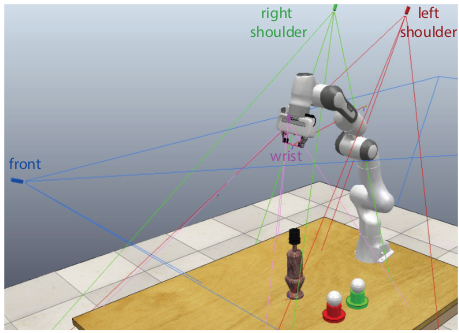

Camera Intrinsics (same for all cams):
```
tensor([[[[-175.8386,    0.0000,   64.0000],
          [   0.0000, -175.8386,   64.0000],
          [   0.0000,    0.0000,    1.0000]]]], device='cuda:0')
```

Camera Extrinsics (`left_shoulder_camera_extrinsics`):
```
tensor([[[[ 1.7365e-01,  8.9254e-01,  4.1620e-01, -1.7500e-01],
          [ 9.8481e-01, -1.5738e-01, -7.3387e-02,  2.0000e-01],
          [-1.7881e-07,  4.2262e-01, -9.0631e-01,  1.9800e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]]],
       device='cuda:0')
```

#### Voxel Details
- `obs` : 4 x 2 x torch.Size([1, 3, 128, 128]) : ?
- `pcd_flat` : torch.Size([1, 65536, 3]) : point cloud flattened 


#### Input Observation
Following James et al. [14], our input voxel observation is a 100 3 voxel grid
with 10 channels: R 100×100×100×10 . The grid is constructed by fusing calibrated pointclouds with
PyTorch’s scatter function 5 . 

The 10 channels are composed of: 
- 3 RGB: The RGB values are normalized to a zero-mean distribution.
- 3 point: The point values are Cartesian coordinates in the robot’s coordinate frame.
- 1 occupancy: The occupancy value indicates if a voxel is occupied or empty.
- 3 position index values: The position index values represent the 3D location of the voxel with respect to the 100 3 grid.


In addition to the voxel observation, the input also includes proprioception data with 4 scalar values: gripper open, left finger joint position, right finger joint position, and
timestep (of the action sequence).

In [ ]:
# render voxel grid with expert action (blue)
#@markdown #### Show voxel grid and expert action (blue)
#@markdown Adjust `rotation_amount` to change the camera yaw angle for rendering.
# rotation_amount = 0 #@param {type:"slider", min:-180, max:180, step:5}
rotation_amount = 0 #@param {type:"slider", min:-180, max:180, step:5}
rendered_img = visualise_voxel(vis_voxel_grid[0],
                               None,
                               None,
                               vis_gt_coord[0],
                               voxel_size=0.045,
                               rotation_amount=np.deg2rad(rotation_amount))

fig = plt.figure(figsize=(15, 15))
plt.imshow(rendered_img)
plt.axis('off')

print(f"Lang goal: {lang_goal}")

In [ ]:
vis_voxel_grid[0].transpose((1, 2, 3, 0))[50,10,30]

In [ ]:
vis_voxel_grid[0].shape

In [ ]:
vis_gt_coord[0]

In [ ]:
vis_gt_coord.shape

In [ ]:
# Use Visualization Function

# import torch
# import numpy as np
# from scipy.spatial.transform import Rotation

# import pyrender
# import trimesh
# from pyrender.trackball import Trackball


# From https://github.com/stepjam/ARM/blob/main/arm/c2farm/voxel_grid.py

# from functools import reduce as funtool_reduce
# from operator import mul

# import torch
# from torch import nn, einsum
# import torch.nn.functional as F

# MIN_DENOMINATOR = 1e-12
# INCLUDE_PER_VOXEL_COORD = False


# class VoxelGrid(nn.Module):

#     def __init__(self,
#                  coord_bounds,
#                  voxel_size: int,
#                  device,
#                  batch_size,
#                  feature_size,
#                  max_num_coords: int,):
#         super(VoxelGrid, self).__init__()
#         self._device = device
#         self._voxel_size = voxel_size
#         self._voxel_shape = [voxel_size] * 3
#         self._voxel_d = float(self._voxel_shape[-1])
#         self._voxel_feature_size = 4 + feature_size
#         self._voxel_shape_spec = torch.tensor(self._voxel_shape,
#                                               device=device).unsqueeze(
#             0) + 2  # +2 because we crop the edges.
#         self._coord_bounds = torch.tensor(coord_bounds, dtype=torch.float,
#                                           device=device).unsqueeze(0)
#         max_dims = self._voxel_shape_spec[0]
#         self._total_dims_list = torch.cat(
#             [torch.tensor([batch_size], device=device), max_dims,
#              torch.tensor([4 + feature_size], device=device)], -1).tolist()
#         self._ones_max_coords = torch.ones((batch_size, max_num_coords, 1),
#                                            device=device)
#         self._num_coords = max_num_coords

#         shape = self._total_dims_list

#         self._result_dim_sizes = torch.tensor(
#             [funtool_reduce(mul, shape[i + 1:], 1) for i in range(len(shape) - 1)] + [
#                 1], device=device)
#         flat_result_size = funtool_reduce(mul, shape, 1)

#         self._initial_val = torch.tensor(0, dtype=torch.float,
#                                          device=device)
#         self._flat_output = torch.ones(flat_result_size, dtype=torch.float,
#                                        device=device) * self._initial_val
#         self._arange_to_max_coords = torch.arange(4 + feature_size,
#                                                   device=device)
#         self._flat_zeros = torch.zeros(flat_result_size, dtype=torch.float,
#                                        device=device)

#         self._const_1 = torch.tensor(1.0, device=device)
#         self._batch_size = batch_size

#         # Coordinate Bounds:
#         self._bb_mins = self._coord_bounds[..., 0:3]
#         bb_maxs = self._coord_bounds[..., 3:6]
#         bb_ranges = bb_maxs - self._bb_mins
#         # get voxel dimensions. 'DIMS' mode
#         self._dims = dims = self._voxel_shape_spec.int()
#         self._dims_orig = dims_orig = self._voxel_shape_spec.int() - 2
#         self._dims_m_one = (dims - 1).int()
#         # BS x 1 x 3
#         self._res = bb_ranges / (dims_orig.float() + MIN_DENOMINATOR)
#         self._res_minis_2 = bb_ranges / (dims.float() - 2 + MIN_DENOMINATOR)

#         self._voxel_indicy_denmominator = self._res + MIN_DENOMINATOR
#         self._dims_m_one_zeros = torch.zeros_like(self._dims_m_one)

#         batch_indices = torch.arange(self._batch_size, dtype=torch.int,
#                                      device=device).view(self._batch_size, 1, 1)
#         self._tiled_batch_indices = batch_indices.repeat(
#             [1, self._num_coords, 1])

#         w = self._voxel_shape[0] + 2
#         arange = torch.arange(0, w, dtype=torch.float, device=device)
#         self._index_grid = torch.cat([
#             arange.view(w, 1, 1, 1).repeat([1, w, w, 1]),
#             arange.view(1, w, 1, 1).repeat([w, 1, w, 1]),
#             arange.view(1, 1, w, 1).repeat([w, w, 1, 1])], dim=-1).unsqueeze(
#             0).repeat([self._batch_size, 1, 1, 1, 1])

#     def _broadcast(self, src: torch.Tensor, other: torch.Tensor, dim: int):
#         if dim < 0:
#             dim = other.dim() + dim
#         if src.dim() == 1:
#             for _ in range(0, dim):
#                 src = src.unsqueeze(0)
#         for _ in range(src.dim(), other.dim()):
#             src = src.unsqueeze(-1)
#         src = src.expand_as(other)
#         return src

#     def _scatter_mean(self, src: torch.Tensor, index: torch.Tensor, out: torch.Tensor,
#                       dim: int = -1):
#         out = out.scatter_add_(dim, index, src)

#         index_dim = dim
#         if index_dim < 0:
#             index_dim = index_dim + src.dim()
#         if index.dim() <= index_dim:
#             index_dim = index.dim() - 1

#         ones = torch.ones(index.size(), dtype=src.dtype, device=src.device)
#         out_count = torch.zeros(out.size(), dtype=out.dtype, device=out.device)
#         out_count = out_count.scatter_add_(index_dim, index, ones)
#         out_count.clamp_(1)
#         count = self._broadcast(out_count, out, dim)
#         if torch.is_floating_point(out):
#             out.true_divide_(count)
#         else:
#             out.floor_divide_(count)
#         return out

#     def _scatter_nd(self, indices, updates):
#         indices_shape = indices.shape
#         num_index_dims = indices_shape[-1]
#         flat_updates = updates.view((-1,))
#         indices_scales = self._result_dim_sizes[0:num_index_dims].view(
#             [1] * (len(indices_shape) - 1) + [num_index_dims])
#         indices_for_flat_tiled = ((indices * indices_scales).sum(
#             dim=-1, keepdims=True)).view(-1, 1).repeat(
#             *[1, self._voxel_feature_size])

#         implicit_indices = self._arange_to_max_coords[
#                            :self._voxel_feature_size].unsqueeze(0).repeat(
#             *[indices_for_flat_tiled.shape[0], 1])
#         indices_for_flat = indices_for_flat_tiled + implicit_indices
#         flat_indices_for_flat = indices_for_flat.view((-1,)).long()

#         flat_scatter = self._scatter_mean(
#             flat_updates, flat_indices_for_flat,
#             out=torch.zeros_like(self._flat_output))
#         return flat_scatter.view(self._total_dims_list)

#     def coords_to_bounding_voxel_grid(self, coords, coord_features=None,
#                                       coord_bounds=None):
#         voxel_indicy_denmominator = self._voxel_indicy_denmominator
#         res, bb_mins = self._res, self._bb_mins
#         if coord_bounds is not None:
#             bb_mins = coord_bounds[..., 0:3]
#             bb_maxs = coord_bounds[..., 3:6]
#             bb_ranges = bb_maxs - bb_mins
#             res = bb_ranges / (self._dims_orig.float() + MIN_DENOMINATOR)
#             voxel_indicy_denmominator = res + MIN_DENOMINATOR

#         bb_mins_shifted = bb_mins - res  # shift back by one
#         floor = torch.floor(
#             (coords - bb_mins_shifted.unsqueeze(1)) / voxel_indicy_denmominator.unsqueeze(1)).int()
#         voxel_indices = torch.min(floor, self._dims_m_one)
#         voxel_indices = torch.max(voxel_indices, self._dims_m_one_zeros)

#         # global-coordinate point cloud (x, y, z)
#         voxel_values = coords

#         # rgb values (R, G, B)
#         if coord_features is not None:
#             voxel_values = torch.cat([voxel_values, coord_features], -1) # concat rgb values (B, 128, 128, 3)

#         # coordinates to aggregate over
#         _, num_coords, _ = voxel_indices.shape
#         all_indices = torch.cat([
#             self._tiled_batch_indices[:, :num_coords], voxel_indices], -1)

#         # max coordinates
#         voxel_values_pruned_flat = torch.cat(
#             [voxel_values, self._ones_max_coords[:, :num_coords]], -1)

#         # aggregate across camera views
#         scattered = self._scatter_nd(
#             all_indices.view([-1, 1 + 3]),
#             voxel_values_pruned_flat.view(-1, self._voxel_feature_size))

#         vox = scattered[:, 1:-1, 1:-1, 1:-1]
#         if INCLUDE_PER_VOXEL_COORD:
#             res_expanded = res.unsqueeze(1).unsqueeze(1).unsqueeze(1)
#             res_centre = (res_expanded * self._index_grid) + res_expanded / 2.0
#             coord_positions = (res_centre + bb_mins_shifted.unsqueeze(
#                 1).unsqueeze(1).unsqueeze(1))[:, 1:-1, 1:-1, 1:-1]
#             vox = torch.cat([vox[..., :-1], coord_positions, vox[..., -1:]], -1)

#         # occupied value
#         occupied = (vox[..., -1:] > 0).float()
#         vox = torch.cat([
#             vox[..., :-1], occupied], -1)

#         # hard voxel-location position encoding
#         return torch.cat(
#            [vox[..., :-1], self._index_grid[:, :-2, :-2, :-2] / self._voxel_d,
#             vox[..., -1:]], -1)


# def _compute_initial_camera_pose(scene):
#     # Adapted from:
#     # https://github.com/mmatl/pyrender/blob/master/pyrender/viewer.py#L1032
#     centroid = scene.centroid
#     scale = scene.scale
#     # if scale == 0.0:
#     #     scale = DEFAULT_SCENE_SCALE
#     scale = 4.0
#     s2 = 1.0 / np.sqrt(2.0)
#     cp = np.eye(4)
#     cp[:3, :3] = np.array([[0.0, -s2, s2], [1.0, 0.0, 0.0], [0.0, s2, s2]])
#     hfov = np.pi / 6.0
#     dist = scale / (2.0 * np.tan(hfov))
#     cp[:3, 3] = dist * np.array([1.0, 0.0, 1.0]) + centroid
#     return cp

# def _from_trimesh_scene(
#         trimesh_scene, bg_color=None, ambient_light=None):
#     # convert trimesh geometries to pyrender geometries
#     geometries = {name: pyrender.Mesh.from_trimesh(geom, smooth=False)
#                   for name, geom in trimesh_scene.geometry.items()}
#     # create the pyrender scene object
#     scene_pr = pyrender.Scene(bg_color=bg_color, ambient_light=ambient_light)
#     # add every node with geometry to the pyrender scene
#     for node in trimesh_scene.graph.nodes_geometry:
#         pose, geom_name = trimesh_scene.graph[node]
#         scene_pr.add(geometries[geom_name], pose=pose)
#     return scene_pr


# def create_voxel_scene(
#         voxel_grid: np.ndarray,
#         q_attention: np.ndarray = None,
#         highlight_coordinate: np.ndarray = None,
#         highlight_gt_coordinate: np.ndarray = None,
#         highlight_alpha: float = 1.0,
#         voxel_size: float = 0.1,
#         show_bb: bool = False,
#         alpha: float = 0.5):
#     _, d, h, w = voxel_grid.shape
#     v = voxel_grid.transpose((1, 2, 3, 0))
#     occupancy = v[:, :, :, -1] != 0
#     alpha = np.expand_dims(np.full_like(occupancy, alpha, dtype=np.float32), -1)
#     rgb = np.concatenate([(v[:, :, :, 3:6] + 1)/ 2.0, alpha], axis=-1)

#     if q_attention is not None:
#         q = np.max(q_attention, 0)
#         q = q / np.max(q)
#         show_q = (q > 0.75)
#         occupancy = (show_q + occupancy).astype(bool)
#         q = np.expand_dims(q - 0.5, -1)  # Max q can be is 0.9
#         q_rgb = np.concatenate([
#             q, np.zeros_like(q), np.zeros_like(q),
#             np.clip(q, 0, 1)], axis=-1)
#         rgb = np.where(np.expand_dims(show_q, -1), q_rgb, rgb)

#     if highlight_coordinate is not None:
#         x, y, z = highlight_coordinate
#         occupancy[x, y, z] = True
#         rgb[x, y, z] = [1.0, 0.0, 0.0, highlight_alpha]

#     if highlight_gt_coordinate is not None:
#         x, y, z = highlight_gt_coordinate
#         occupancy[x, y, z] = True
#         rgb[x, y, z] = [0.0, 0.0, 1.0, highlight_alpha]

#     transform = trimesh.transformations.scale_and_translate(
#         scale=voxel_size, translate=(0.0, 0.0, 0.0))
#     trimesh_voxel_grid = trimesh.voxel.VoxelGrid(
#         encoding=occupancy, transform=transform)
#     geometry = trimesh_voxel_grid.as_boxes(colors=rgb)
#     scene = trimesh.Scene()
#     scene.add_geometry(geometry)
#     if show_bb:
#         assert d == h == w
#         _create_bounding_box(scene, voxel_size, d)
#     return scene


# def visualise_voxel(voxel_grid: np.ndarray,
#                     q_attention: np.ndarray = None,
#                     highlight_coordinate: np.ndarray = None,
#                     highlight_gt_coordinate: np.ndarray = None,
#                     highlight_alpha: float = 1.0,
#                     rotation_amount: float = 0.0,
#                     show: bool = False,
#                     voxel_size: float = 0.1,
#                     offscreen_renderer: pyrender.OffscreenRenderer = None,
#                     show_bb: bool = False,
#                     alpha: float = 0.5,
#                     render_gripper=False,
#                     gripper_pose=None,
#                     gripper_mesh_scale=1.0):
#     scene = create_voxel_scene(
#         voxel_grid, q_attention, highlight_coordinate, highlight_gt_coordinate,
#         highlight_alpha, voxel_size,
#         show_bb, alpha)
#     if show:
#         scene.show()
#     else:
#         r = offscreen_renderer or pyrender.OffscreenRenderer(
#             viewport_width=1920, viewport_height=1080, point_size=1.0)
#         s = _from_trimesh_scene(
#             scene, ambient_light=[0.8, 0.8, 0.8],
#             bg_color=[1.0, 1.0, 1.0])
#         cam = pyrender.PerspectiveCamera(
#             yfov=np.pi / 4.0, aspectRatio=r.viewport_width/r.viewport_height)
#         p = _compute_initial_camera_pose(s)
#         t = Trackball(p, (r.viewport_width, r.viewport_height), s.scale, s.centroid)
#         t.rotate(rotation_amount, np.array([0.0, 0.0, 1.0]))
#         s.add(cam, pose=t.pose)

#         if render_gripper:
#             gripper_trimesh = trimesh.load('peract_colab/meshes/hand.dae', force='mesh')
#             gripper_trimesh.vertices *= gripper_mesh_scale
#             radii = np.linalg.norm(gripper_trimesh.vertices - gripper_trimesh.center_mass, axis=1)
#             gripper_trimesh.visual.vertex_colors = trimesh.visual.interpolate(radii * gripper_mesh_scale, color_map='winter')
#             gripper_mesh = pyrender.Mesh.from_trimesh(gripper_trimesh, poses=np.array([gripper_pose]), smooth=False)
#             s.add(gripper_mesh) 
#         color, depth = r.render(s)
#         return color.copy()


